In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/works/client-project/stock-inventory-business-case/project-group.zip (Unzipped Files)

/content/drive/MyDrive/works/client-project/stock-inventory-business-case/project-group.zip (Unzipped Files)


In [ ]:
%pwd

'/content'

# **Approach 2:**
Build a time-series model for top 3 classes to forecast spare-parts counts on given date.

For building a more suitable time-series model, we try with different time-series techniques. Here we use;
- AutoRegression (AR)
- AutoRegression Integerated Moving Average (ARIMA)
- Seasonal ARIMA
- FBProphet

Here we use three dataset that prepared on part1. i.e, 'ENGINE OIL', 'CHAIN LUBRICATION' and 'GENERAL SERVICE'.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **Applying AR, ARIMA and SARIMA**
#### **ENGINE OIL**

In [45]:
engineoil_df = pd.read_csv('engine_oil_tsdata.csv', parse_dates=['Date'])
engineoil_df

,Date,Engine Oil Quantity
0,2017-01-06,8
1,2017-01-07,12
2,2017-01-08,6
3,2017-01-09,7
4,2017-01-10,3
...,...,...
547,2019-01-02,6
548,2019-01-03,6
549,2019-01-04,11
550,2019-01-05,11


In [ ]:
engineoil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 552 non-null    datetime64[ns]
 1   Engine Oil Quantity  552 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.8 KB


In [46]:
engineoil_df.set_index('Date', inplace=True)

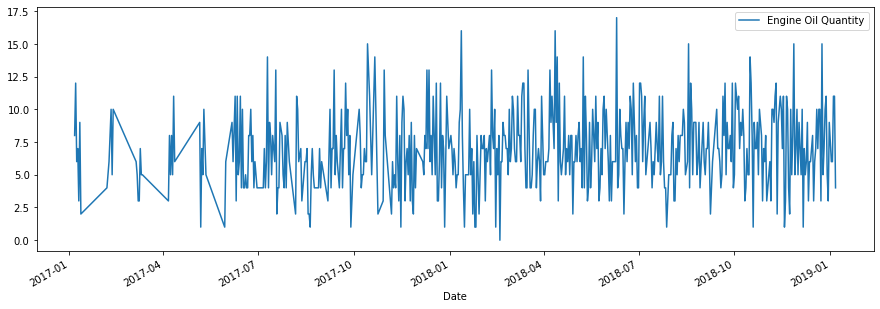

In [ ]:
engineoil_df.plot(figsize=(15, 5))

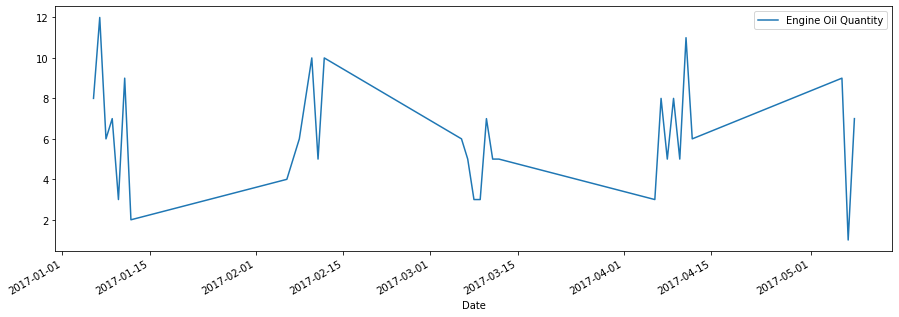

In [ ]:
engineoil_df[:30].plot(figsize=(15, 5))

**Check stationarity**

In [ ]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def check_adfuller(data_df):
  adf_result = adfuller(data_df, autolag='AIC')
  
  print('\nAugmented Dickey-Fuller Test:')
  labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

  for value, label in zip(adf_result, labels):
    print(label+' : '+str(value))
    
  for key, value in adf_result[4].items():
    print('\tCrtical {} : value {}'.format(key,value))

  if adf_result[1] <= 0.05: # => H1
    return "strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary"
  else: # => H0
    return "weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary "

In [ ]:
check_adfuller(engineoil_df['Engine Oil Quantity'])


Augmented Dickey-Fuller Test:
ADF Test Statistic : -23.595132662966304
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 551
	Crtical 1% : value -3.442273822587951
	Crtical 5% : value -2.8667997388278583
	Crtical 10% : value -2.5695712667942465


'strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary'

**Checking Autocorrelation**

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

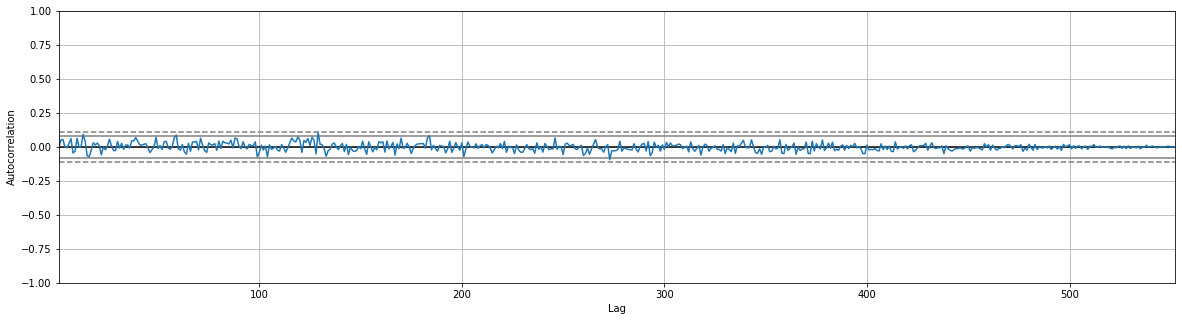

In [ ]:
plt.figure(figsize=(20, 5))
autocorrelation_plot(engineoil_df['Engine Oil Quantity'])
plt.show()

Above autocorrelation plot shows that for all lags there is no any significant coefficient for this series data. All coefficient values are bounds to zero.

But lets try with models

**Get order('p') of AR model from PACF graph**

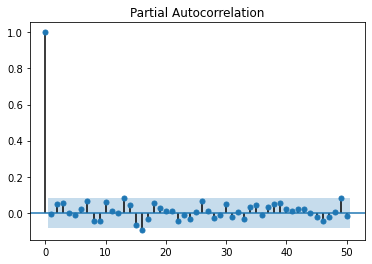

<Figure size 1440x360 with 0 Axes>

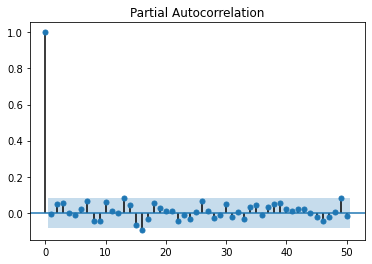

In [ ]:
plt.figure(figsize=(20, 5))
plot_pacf(engineoil_df['Engine Oil Quantity'], lags=50)

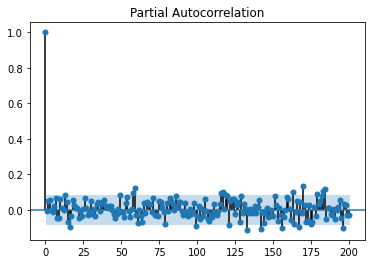

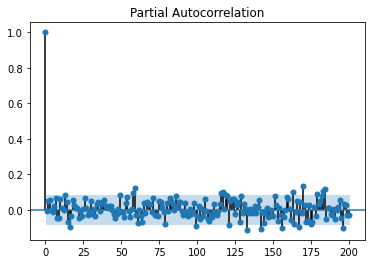

In [ ]:
plot_pacf(engineoil_df['Engine Oil Quantity'], lags=200)

As we found in Autocorrelation, PACF does not have more initial significant lags.

Since we are unable to get exact order 'p' value for Auto Regressive model, will try AR model with different values for order 'p' from 16, 58, 59, 130-135, 170-175 and 190-195. These values seems to be have signifciant correlations from PACF plot. Then check the correspoding AIC and BIC score.

**AR model**

In [4]:
! pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 28.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [5]:
from statsmodels.tsa.ar_model import AutoReg

In [47]:
test_size = 0.10*engineoil_df.shape[0]
engineoil_df_train = engineoil_df.iloc[:engineoil_df.shape[0]-int(test_size)]
engineoil_df_test = engineoil_df.iloc[-int(test_size):]

In [ ]:
engineoil_df_train['Engine Oil Quantity']

Date
2017-01-06     8
2017-01-07    12
2017-01-08     6
2017-01-09     7
2017-01-10     3
              ..
2018-11-07    10
2018-11-08     9
2018-11-09    11
2018-11-10    12
2018-11-11     2
Name: Engine Oil Quantity, Length: 497, dtype: int64

In [ ]:
## selecting 'p' values that have significant correlation coefficient

order_p = [16, 58, 59, 130, 131, 132, 133, 134, 135, 170, 171, 172, 173, 174, 175, 178, 190, 191, 192, 193, 194, 195]
ar_aic_scores = []
ar_bic_scores = []
for p in order_p:
  model = AutoReg(engineoil_df_train['Engine Oil Quantity'], lags=p)
  model_fit = model.fit()
  ar_aic_scores.append(model_fit.aic)
  ar_bic_scores.append(model_fit.bic)

In [ ]:
ar_bic_scores

[2500.0530792217196,
 2523.5480726708533,
 2519.7354765355226,
 2502.4170337178157,
 2502.090003553072,
 2503.7305004699583,
 2497.014797469827,
 2496.463897354378,
 2497.5335341908985,
 2441.216322782383,
 2441.9507682145627,
 2441.4137784977092,
 2442.6039675608563,
 2434.294620691994,
 2435.0979112413106,
 2417.2772173644676,
 2385.6872496394035,
 2378.3394076695536,
 2380.2403038099983,
 2382.0942294770375,
 2381.409694182549,
 2382.0551145156883]

In [ ]:
ar_aic_scores

[2424.887468359816,
 2278.478107886343,
 2270.7201230025594,
 1986.9092697746123,
 1983.0397702106907,
 1981.1442550899046,
 1970.8990253388672,
 1966.825111894358,
 1964.378277170768,
 1789.3431733880552,
 1786.8175212381223,
 1783.0281967723351,
 1780.9738522971986,
 1769.4278118048067,
 1767.00228767995,
 1739.5428188631956,
 1670.1324821026617,
 1659.6874829927442,
 1658.4998191481607,
 1657.2738277028245,
 1653.5180643027131,
 1651.1009920928389]

lag 191 has low aic (1659.68) as well as bic (2378.34) score, so let choose 191.

In [48]:
model_ar_engineoil = AutoReg(engineoil_df_train['Engine Oil Quantity'], lags=191)
model_ar_engineoil_fit = model_ar_engineoil.fit()
model_ar_engineoil_fit.bic

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2378.3394076695536

In [ ]:
model_ar_engineoil_fit.summary()

In [49]:
## Forcasting

start = len(engineoil_df_train)
end=len(engineoil_df_train)+len(engineoil_df_test)-1

engineoil_pred_ar = model_ar_engineoil_fit.predict(start=start, end=end, dynamic=False)
engineoil_pred_ar.index = engineoil_df.index[start:end+1]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


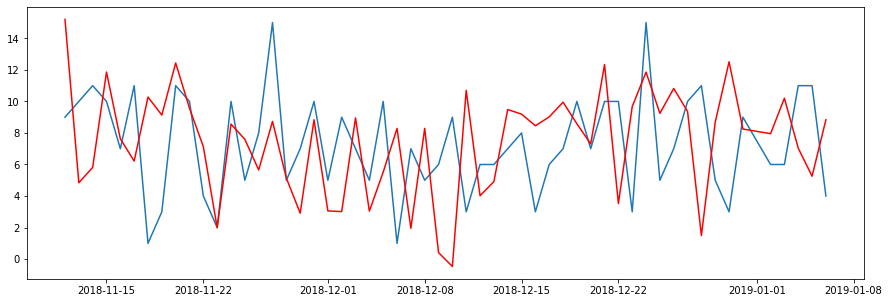

In [50]:
plt.figure(figsize=(15, 5))
plt.plot(engineoil_df_test)
plt.plot(engineoil_pred_ar, color='red')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
sqrt(mean_squared_error(engineoil_df_test, engineoil_pred_ar))

4.5703435557123715

**ARIMA model**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

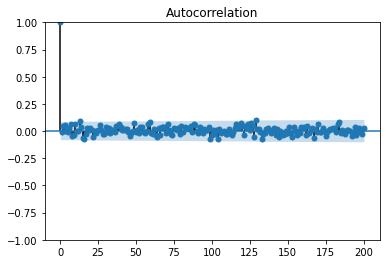

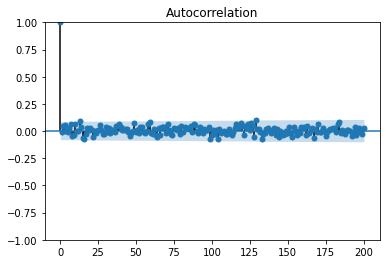

In [ ]:
## for getting order 'q' value for MA in ARIMA
plot_acf(engineoil_df['Engine Oil Quantity'], lags=200)

In ACF plot also there is no any lag with significant coefficient value.

In [ ]:
! pip install pmdarima

In [ ]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Figure out order of ARIMA model (p, d, q)

stepwise_fit_bic = auto_arima(engineoil_df_train['Engine Oil Quantity'], trace=True, information_criterion='bic', suppress_warnings=True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=1.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=2831.466, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=2673.783, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=2825.264, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=2626.390, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : BIC=2607.916, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : BIC=2602.006, Time=0.23 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : BIC=2591.595, Time=0.24 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=1.39 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=1.08 sec
 ARIMA(5,1,0)(0,0,0)[0]             : BIC=2585.389, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0]             : BIC=2595.800, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0]             : BIC=2524.767, Time=0.39 sec
 ARIMA(4,1,1)(0,0,0)[0]             : BIC=2519.311, T

In [ ]:
stepwise_fit_aic = auto_arima(engineoil_df_train['Engine Oil Quantity'], trace=True, information_criterion='aic', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2823.053, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2661.163, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2821.057, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2609.563, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2586.883, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2576.767, Time=0.23 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2562.149, Time=0.24 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2560.149, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2574.767, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2495.321, Time=0.41 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2494.072, T

In [ ]:
model_arima_engineoil = ARIMA(engineoil_df_train, order=(0,1,1)) # p,d,q
model_arima_engineoil_fit = model_arima_engineoil.fit()
model_arima_engineoil_fit.aic

2488.076167437786

In [ ]:
model_arima_engineoil_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Engine Oil Quantity   No. Observations:                  497
Model:                  ARIMA(0, 1, 1)   Log Likelihood               -1242.038
Date:                 Mon, 18 Jul 2022   AIC                           2488.076
Time:                         13:10:52   BIC                           2496.489
Sample:                              0   HQIC                          2491.379
                                 - 497                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9880      0.008   -120.845      0.000      -1.004      -0.972
sigma2         8.6955      0.544     15.998      0.000       7.630       9.761
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                16.06
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.44
Prob(H) (two-sided):                  0.67   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
## Forcasting

engineoil_pred_arima = model_arima_engineoil_fit.predict(start=start, end=end, dynamic=False)
engineoil_pred_arima.index = engineoil_df.index[start:end+1]

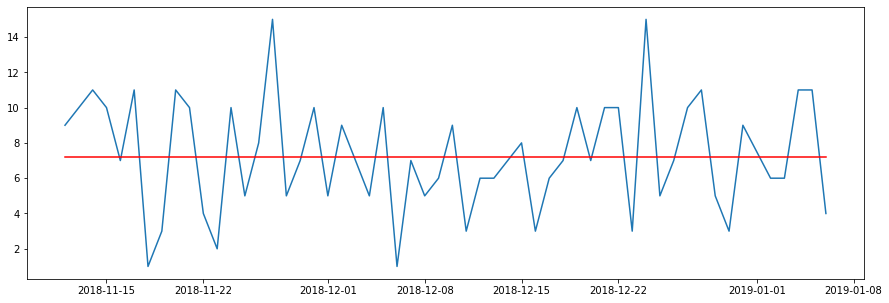

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(engineoil_df_test)
plt.plot(engineoil_pred_arima, color='red')
plt.show()

For ARIMA even though both AIC and BIC score is high compared to Auto Regressive model, prediction is also very poor.

**SARIMA model**

In [ ]:
%pwd

'/content/drive/My Drive/colab/client-project/stock-inventory-business-case'

In [ ]:
import statsmodels.api as sm

In [ ]:
model_sarima_engineoil = sm.tsa.statespace.SARIMAX(engineoil_df_train['Engine Oil Quantity'],order=(5, 0, 1),seasonal_order=(5,0,1,28))
model_sarima_engineoil_fit = model_sarima_engineoil.fit()

In [ ]:
model_sarima_engineoil_fit.aic

2510.594208940147

In [ ]:
## Forcasting

engineoil_pred_sarima = model_sarima_engineoil_fit.predict(start=start, end=end, dynamic=True)
engineoil_pred_sarima.index = engineoil_df.index[start:end+1]

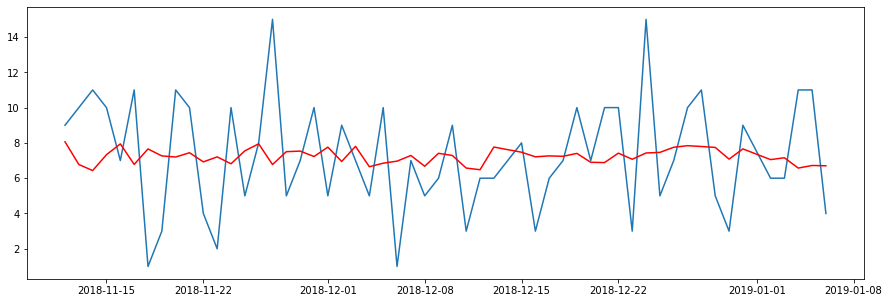

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(engineoil_df_test)
plt.plot(engineoil_pred_sarima, color='red')
plt.show()

In [ ]:
sqrt(mean_squared_error(engineoil_df_test, engineoil_pred_sarima))

3.2265095403177435

For Engine oil data;
- AutoReg model is comparitively better against ARIMA and SARIMA. Have AIC score 1659.68 and RMSE is 4.57.
- SARIMA is better than ARIMA. AIC: 2510.59, RMSE: 3.22

#### **CHAIN LUBRICATION**

In [51]:
chainlubrication_df = pd.read_csv('chain_lubrication_tsdata.csv', parse_dates=['Date'])
chainlubrication_df

,Date,Chain Lubrication Quantity
0,2017-01-06,5
1,2017-01-07,9
2,2017-01-08,7
3,2017-01-09,5
4,2017-01-10,2
...,...,...
547,2019-01-02,5
548,2019-01-03,4
549,2019-01-04,10
550,2019-01-05,9


In [52]:
chainlubrication_df.set_index('Date', inplace=True)

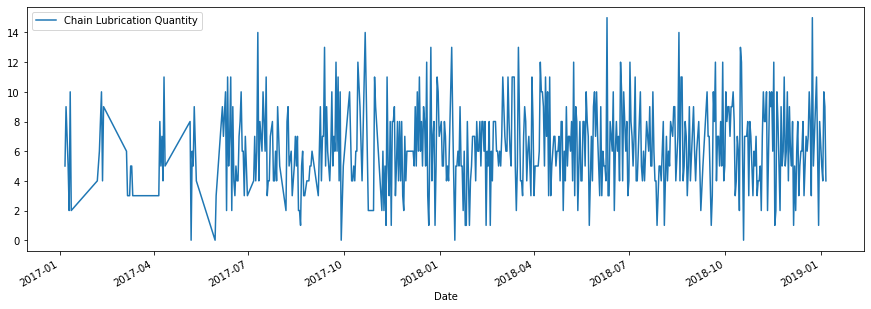

In [ ]:
chainlubrication_df.plot(figsize=(15, 5))

**Check stationarity**

In [ ]:
check_adfuller(chainlubrication_df['Chain Lubrication Quantity'])


Augmented Dickey-Fuller Test:
ADF Test Statistic : -24.40288444110066
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 551
	Crtical 1% : value -3.442273822587951
	Crtical 5% : value -2.8667997388278583
	Crtical 10% : value -2.5695712667942465


'strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary'

**Checking Autocorrelation**

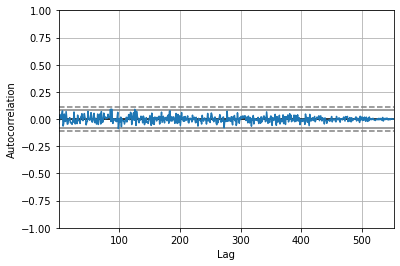

In [ ]:
autocorrelation_plot(chainlubrication_df['Chain Lubrication Quantity'])
plt.show()

Same as Engine oil, not have much significant lags.

**PACF plot**

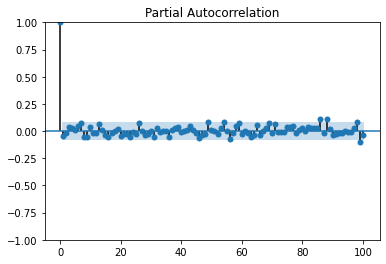

<Figure size 1440x360 with 0 Axes>

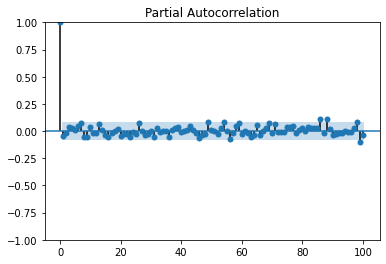

In [ ]:
plt.figure(figsize=(20, 5))
plot_pacf(chainlubrication_df['Chain Lubrication Quantity'], lags=100)

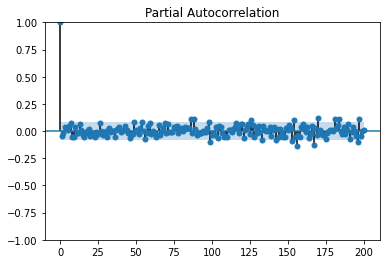

<Figure size 1440x360 with 0 Axes>

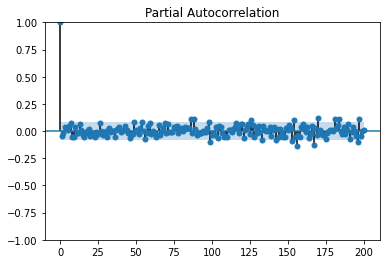

In [ ]:
plt.figure(figsize=(20, 5))
plot_pacf(chainlubrication_df['Chain Lubrication Quantity'], lags=200)

**AR model**

In [53]:
test_size = 0.10*chainlubrication_df.shape[0]
chainlubrication_df_train = chainlubrication_df.iloc[:chainlubrication_df.shape[0]-int(test_size)]
chainlubrication_df_test = chainlubrication_df.iloc[-int(test_size):]

In [ ]:
## selecting 'p' values that have significant correlation coefficient

order_p = [85, 86, 87, 88, 89, 90, 96, 97, 98, 99, 100]
for i in range(150, 200):
  order_p.append(i)
order_p

In [ ]:
ar_aic_scores = []
ar_bic_scores = []
for p in order_p:
  model = AutoReg(chainlubrication_df_train['Chain Lubrication Quantity'], lags=p)
  model_fit = model.fit()
  ar_aic_scores.append(model_fit.aic)
  ar_bic_scores.append(model_fit.bic)

In [ ]:
ar_aic_scores

In [ ]:
ar_bic_scores

In [ ]:
order_p[-11]

189

lag 189 has low aic (1675.19) as well as bic (2387.64) score, so let choose 189.

In [54]:
model_ar_chainlubrication = AutoReg(chainlubrication_df_train['Chain Lubrication Quantity'], lags=189)
model_ar_chainlubrication_fit = model_ar_chainlubrication.fit()
model_ar_chainlubrication_fit.bic

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2387.641214974285

In [55]:
## Forcasting

start = len(chainlubrication_df_train)
end=len(chainlubrication_df_train)+len(chainlubrication_df_test)-1

chainlubrication_pred_ar = model_ar_chainlubrication_fit.predict(start=start, end=end, dynamic=False)
chainlubrication_pred_ar.index = chainlubrication_df.index[start:end+1]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


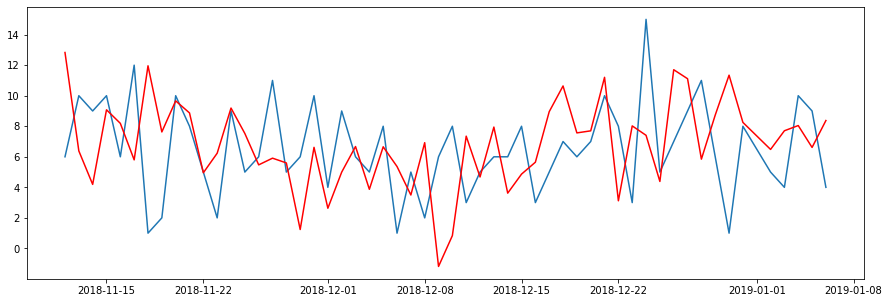

In [56]:
plt.figure(figsize=(15, 5))
plt.plot(chainlubrication_df_test)
plt.plot(chainlubrication_pred_ar, color='red')
plt.show()

In [ ]:
sqrt(mean_squared_error(chainlubrication_df_test, chainlubrication_pred_ar))

4.1171338722477575

**ARIMA model**

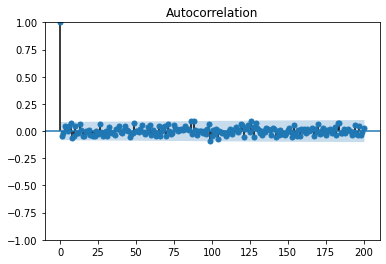

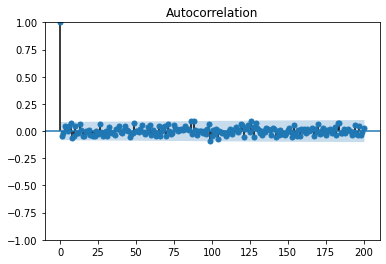

In [ ]:
## for getting order 'q' value for MA in ARIMA
plot_acf(chainlubrication_df['Chain Lubrication Quantity'], lags=200)

No any significant coefficients.

In [ ]:
# Figure out order of ARIMA model (p, d, q)

stepwise_fit_bic = auto_arima(chainlubrication_df_train['Chain Lubrication Quantity'], trace=True, information_criterion='aic', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2448.166, Time=0.88 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2440.664, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2442.267, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2442.266, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3319.179, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2444.266, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.179 seconds


In [ ]:
model_arima_chainlubrication= ARIMA(chainlubrication_df_train, order=(0,0,0)) # p,d,q
model_arima_chainlubrication_fit = model_arima_chainlubrication.fit()
model_arima_chainlubrication_fit.aic

2440.664179658085

In [ ]:
model_arima_chainlubrication_fit.bic

2449.081359710278

In [ ]:
model_arima_chainlubrication_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                    
======================================================================================
Dep. Variable:     Chain Lubrication Quantity   No. Observations:                  497
Model:                                  ARIMA   Log Likelihood               -1218.332
Date:                        Tue, 19 Jul 2022   AIC                           2440.664
Time:                                06:34:31   BIC                           2449.081
Sample:                                     0   HQIC                          2443.968
                                        - 497                                         
Covariance Type:                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2032      0.130     47.778      0.000       5.949       6.458
sigma2         7.8842      0.537     14.671      0.000       6.831       8.938
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):                 9.51
Prob(Q):                              0.53   Prob(JB):                         0.01
Heteroskedasticity (H):               0.93   Skew:                             0.33
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
## Forcasting

chainlubrication_pred_arima = model_arima_chainlubrication_fit.predict(start=start, end=end, dynamic=False)
chainlubrication_pred_arima.index = chainlubrication_df.index[start:end+1]

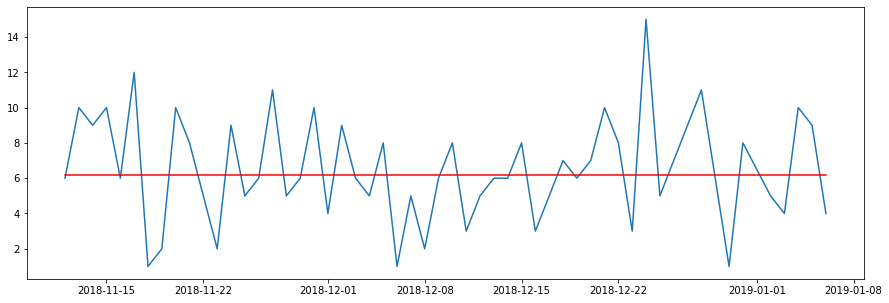

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(chainlubrication_df_test)
plt.plot(chainlubrication_pred_arima, color='red')
plt.show()

**SARIMA model**

In [ ]:
model_sarima_chainlubrication = sm.tsa.statespace.SARIMAX(chainlubrication_df_train['Chain Lubrication Quantity'],order=(1, 0, 1),seasonal_order=(1,0,1,24))
model_sarima_chainlubrication_fit = model_sarima_chainlubrication.fit()

In [ ]:
model_sarima_chainlubrication_fit.aic

2455.7966868849862

In [ ]:
## Forcasting

chainlubrication_pred_sarima = model_sarima_chainlubrication_fit.predict(start=start, end=end, dynamic=True)
chainlubrication_pred_sarima.index = chainlubrication_df.index[start:end+1]

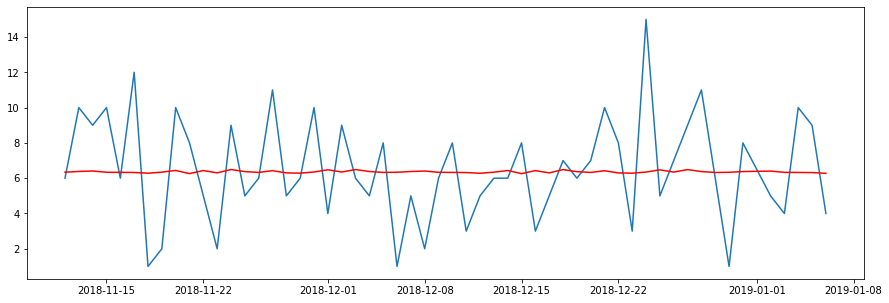

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(chainlubrication_df_test)
plt.plot(chainlubrication_pred_sarima, color='red')
plt.show()

In [ ]:
sqrt(mean_squared_error(chainlubrication_df_test, chainlubrication_pred_sarima))

2.985429327263058

For Chain lubrication data;

- AutoReg model is comparitively better against ARIMA and SARIMA when we consider AIC score. Have AIC score 1675.19 and RMSE is 4.11.
- SARIMA is better than ARIMA. AIC: 2455.79, RMSE: 2.98

#### **GENERAL SERVICE**

In [57]:
generalservice_df = pd.read_csv('general_service_tsdata.csv', parse_dates=['Date'])
generalservice_df

,Date,General Service Quantity
0,2017-01-06,3
1,2017-01-07,9
2,2017-01-08,4
3,2017-01-09,3
4,2017-01-10,2
...,...,...
547,2019-01-02,7
548,2019-01-03,6
549,2019-01-04,6
550,2019-01-05,6


In [58]:
generalservice_df.set_index('Date', inplace=True)

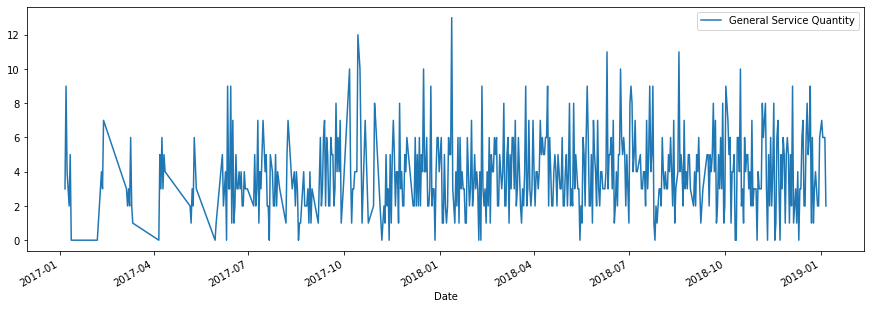

In [ ]:
generalservice_df.plot(figsize=(15, 5))

**Checking Stationarity**

In [ ]:
check_adfuller(generalservice_df['General Service Quantity'])


Augmented Dickey-Fuller Test:
ADF Test Statistic : -23.696103850058222
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 551
	Crtical 1% : value -3.442273822587951
	Crtical 5% : value -2.8667997388278583
	Crtical 10% : value -2.5695712667942465


'strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary'

**Checking Autocorrelation**

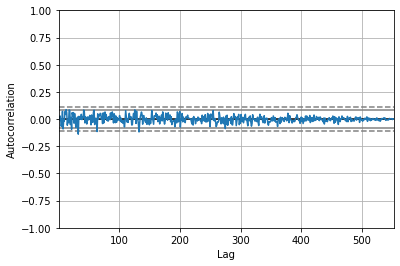

In [ ]:
autocorrelation_plot(generalservice_df['General Service Quantity'])
plt.show()

**PACF plot**

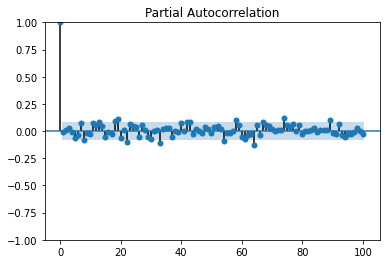

<Figure size 1440x360 with 0 Axes>

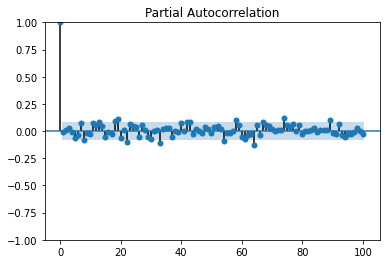

In [ ]:
plt.figure(figsize=(20, 5))
plot_pacf(generalservice_df['General Service Quantity'], lags=100)

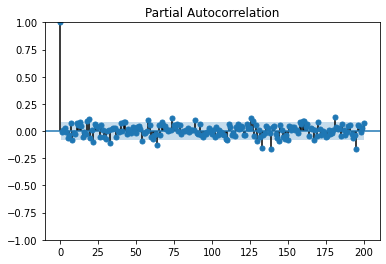

<Figure size 1440x360 with 0 Axes>

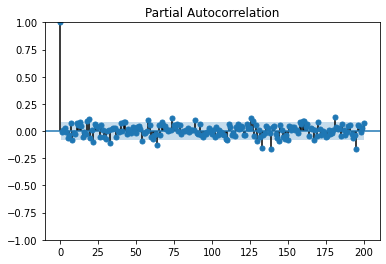

In [ ]:
plt.figure(figsize=(20, 5))
plot_pacf(generalservice_df['General Service Quantity'], lags=200)

**AR model**

In [59]:
test_size = 0.10*generalservice_df.shape[0]
generalservice_df_train = generalservice_df.iloc[:generalservice_df.shape[0]-int(test_size)]
generalservice_df_test = generalservice_df.iloc[-int(test_size):]

In [ ]:
## selecting 'p' values that have significant correlation coefficient

order_p = []
for i in range(60, 80):
  order_p.append(i)

for i in range(85, 95):
  order_p.append(i)

for i in range(120, 145):
  order_p.append(i)

for i in range(170, 196):
  order_p.append(i)

In [ ]:
order_p

In [ ]:
ar_aic_scores = []
ar_bic_scores = []
for p in order_p:
  model = AutoReg(generalservice_df_train['General Service Quantity'], lags=p)
  model_fit = model.fit()
  ar_aic_scores.append(model_fit.aic)
  ar_bic_scores.append(model_fit.bic)

In [ ]:
min(ar_aic_scores)

1466.4161443536257

In [ ]:
min(ar_bic_scores)

2197.370266776475

In [ ]:
ar_aic_scores.index(1466.4161443536257)

80

In [ ]:
ar_bic_scores.index(2197.370266776475)

80

In [ ]:
order_p[80]

195

lag 195 has low aic (1466.41) as well as bic (2197.37) score, so let choose 195.

In [60]:
model_ar_generalservice = AutoReg(generalservice_df_train['General Service Quantity'], lags=195)
model_ar_generalservice_fit = model_ar_generalservice.fit()
model_ar_generalservice_fit.bic

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2197.370266776475

In [61]:
## Forcasting

start = len(generalservice_df_train)
end=len(generalservice_df_train)+len(generalservice_df_test)-1

generalservice_pred_ar = model_ar_generalservice_fit.predict(start=start, end=end, dynamic=False)
generalservice_pred_ar.index = generalservice_df.index[start:end+1]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


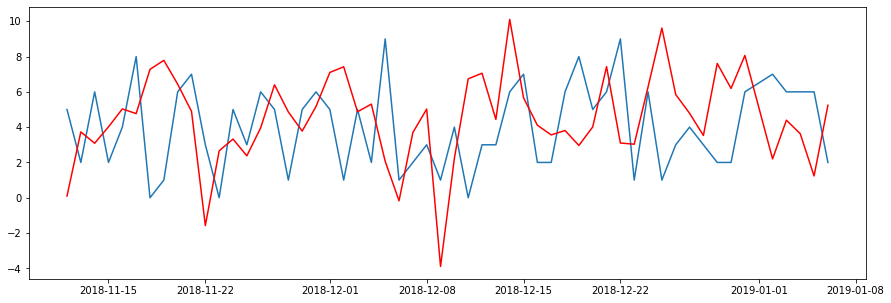

In [62]:
plt.figure(figsize=(15, 5))
plt.plot(generalservice_df_test)
plt.plot(generalservice_pred_ar, color='red')
plt.show()

In [ ]:
sqrt(mean_squared_error(generalservice_df_test, generalservice_pred_ar))

3.597465983019113

**ARIMA model**

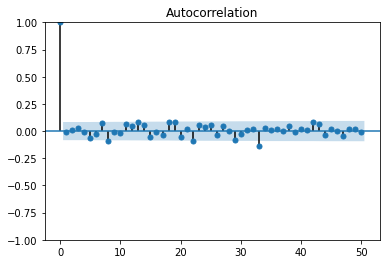

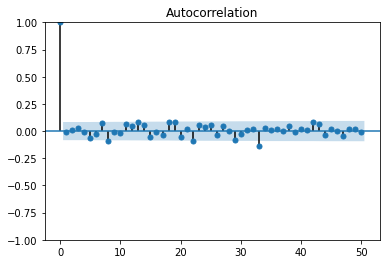

In [ ]:
## for getting order 'q' value for MA in ARIMA
plot_acf(generalservice_df['General Service Quantity'], lags=50)

In [ ]:
# Figure out order of ARIMA model (p, d, q)
stepwise_fit_bic = auto_arima(generalservice_df['General Service Quantity'], trace=True, information_criterion='bic', suppress_warnings=True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=2871.663, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=2710.315, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=2865.352, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=2644.887, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : BIC=2620.352, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : BIC=2615.943, Time=0.22 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : BIC=2609.064, Time=0.24 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=1.67 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=1.85 sec
 ARIMA(5,1,0)(0,0,0)[0]             : BIC=2602.752, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0]             : BIC=2609.631, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0]             : BIC=2513.874, Time=0.41 sec
 ARIMA(4,1,1)(0,0,0)[0]             : BIC=2511.063, T

In [ ]:
model_arima_generalservice = ARIMA(generalservice_df_train, order=(0,1,1)) # p,d,q
model_arima_generalservice_fit = model_arima_generalservice.fit()
model_arima_generalservice_fit.aic

2224.0899000291324

In [ ]:
## Forcasting

generalservice_pred_arima = model_arima_generalservice_fit.predict(start=start, end=end, dynamic=False)
generalservice_pred_arima.index = generalservice_df.index[start:end+1]

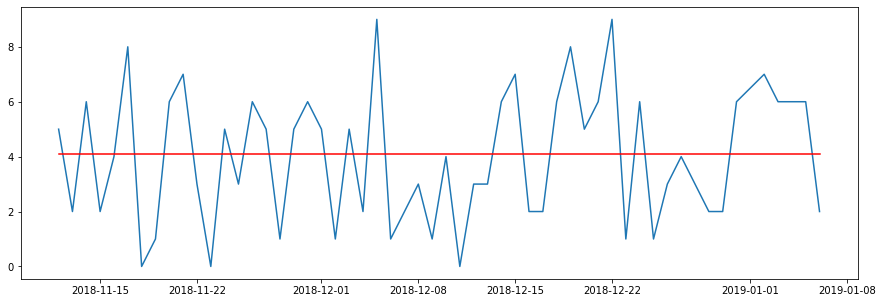

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(generalservice_df_test)
plt.plot(generalservice_pred_arima, color='red')
plt.show()

**SARIMA model**

In [ ]:
model_sarima_generalservice = sm.tsa.statespace.SARIMAX(generalservice_df_train['General Service Quantity'],order=(1, 0, 5),seasonal_order=(1,0,5,24))
model_sarima_generalservice_fit = model_sarima_generalservice.fit()

In [ ]:
model_sarima_generalservice_fit.aic

2340.1891212960536

In [ ]:
## Forcasting

generalservice_pred_sarima = model_sarima_generalservice_fit.predict(start=start, end=end, dynamic=True)
generalservice_pred_sarima.index = generalservice_df.index[start:end+1]

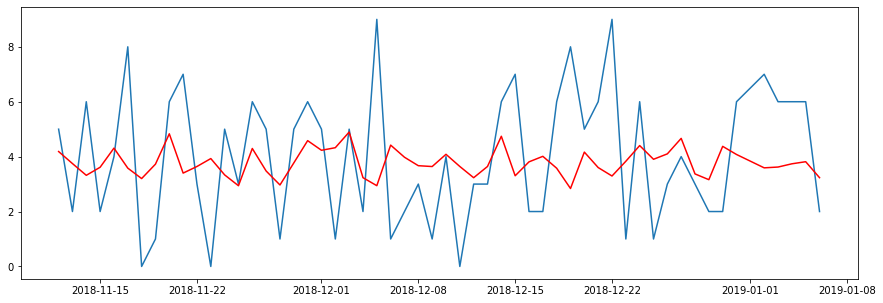

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(generalservice_df_test)
plt.plot(generalservice_pred_sarima, color='red')
plt.show()

In [ ]:
sqrt(mean_squared_error(generalservice_df_test, generalservice_pred_sarima))

2.4761985612875694

For General Service data;
- AutoReg model is comparitively better against ARIMA and SARIMA when we consider AIC score. Have AIC score 1466.41 and RMSE is 3.59.

## **Applying FBProphet**

In [8]:
#! pip install fbprophet
# this above command maynot get installed fbprophet, so try below code

In [9]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 168 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6638406 sha256=8981c6e4ac712f42d7e44b06abc67490be802f591f8a93eed8a966632743285d
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet


In [10]:
import fbprophet
fbprophet.__version__

'0.7.1'

#### **ENGINE OIL**

In [12]:
engineoil_df = pd.read_csv('engine_oil_tsdata.csv')
engineoil_df

,Date,Engine Oil Quantity
0,2017-01-06,8
1,2017-01-07,12
2,2017-01-08,6
3,2017-01-09,7
4,2017-01-10,3
...,...,...
547,2019-01-02,6
548,2019-01-03,6
549,2019-01-04,11
550,2019-01-05,11


In [13]:
# FBProphet expected column names as 'ds' and 'y'
engineoil_df.columns = ['ds', 'y']
engineoil_df['ds']= pd.to_datetime(engineoil_df['ds'])

In [14]:
engineoil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      552 non-null    datetime64[ns]
 1   y       552 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.8 KB


In [15]:
engineoil_df.describe()

,y
count,552.000000
mean,6.887681
std,2.981807
min,0.000000
25%,5.000000
50%,7.000000
75%,9.000000
max,17.000000


In [16]:
test_size = 0.10*engineoil_df.shape[0]
engineoil_df_train = engineoil_df.iloc[:engineoil_df.shape[0]-int(test_size)]
engineoil_df_test = engineoil_df.iloc[-int(test_size):]

In [17]:
engineoil_df_train.tail()

,ds,y
492,2018-11-07,10
493,2018-11-08,9
494,2018-11-09,11
495,2018-11-10,12
496,2018-11-11,2


In [19]:
from fbprophet import Prophet

In [20]:
model_engineoil = Prophet()
model_engineoil.fit(engineoil_df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
## Inorder to forcast on test date, creating a dataframe "future" having test dates.

future = []
for i in list(engineoil_df_test['ds']):
  future.append(str(i).split(' ')[0])

In [22]:
future_df = pd.DataFrame(future)
future_df.columns = ['ds']
future_df['ds']= pd.to_datetime(future_df['ds'])
future_df

,ds
0,2018-11-12
1,2018-11-13
2,2018-11-14
3,2018-11-15
4,2018-11-16
5,2018-11-17
6,2018-11-18
7,2018-11-19
8,2018-11-20
9,2018-11-21


In [23]:
# use the model to make a forecast
engineoil_forecast = model_engineoil.predict(future_df)

In [24]:
engineoil_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
50,2019-01-02,7.577368,3.573857,10.640691,7.577361,7.577376,-0.352551,-0.352551,-0.352551,-0.352551,-0.352551,-0.352551,0.0,0.0,0.0,7.224816
51,2019-01-03,7.579701,3.593552,10.635363,7.579694,7.579709,-0.368627,-0.368627,-0.368627,-0.368627,-0.368627,-0.368627,0.0,0.0,0.0,7.211074
52,2019-01-04,7.582034,4.415797,11.434644,7.582027,7.582043,0.400799,0.400799,0.400799,0.400799,0.400799,0.400799,0.0,0.0,0.0,7.982833
53,2019-01-05,7.584367,5.585092,12.404544,7.584360,7.584376,1.328729,1.328729,1.328729,1.328729,1.328729,1.328729,0.0,0.0,0.0,8.913096
54,2019-01-06,7.586700,2.251703,9.839990,7.586693,7.586710,-1.395872,-1.395872,-1.395872,-1.395872,-1.395872,-1.395872,0.0,0.0,0.0,6.190828


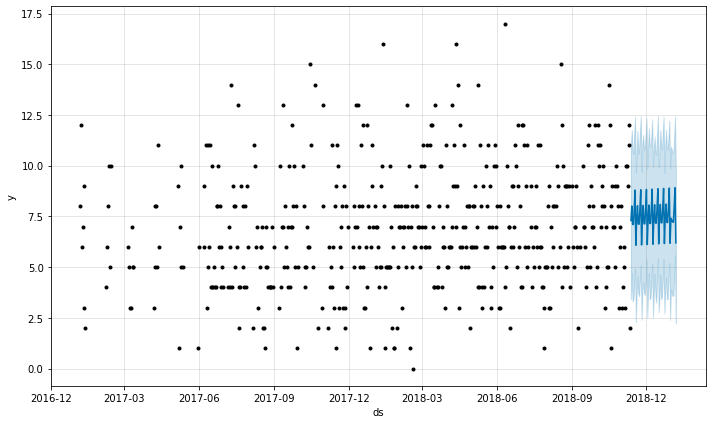

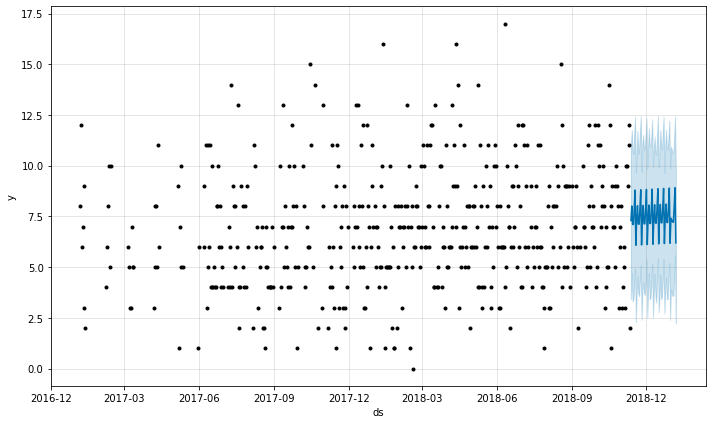

In [25]:
model_engineoil.plot(engineoil_forecast)

FB Prophet is not best suited with Engine oil series data. From above plot we can see it is forecasting in a uniform pattern for a range of dates.

#### **CHAIN LUBRICATION**

In [27]:
chainlubrication_df = pd.read_csv('chain_lubrication_tsdata.csv')
chainlubrication_df

,Date,Chain Lubrication Quantity
0,2017-01-06,5
1,2017-01-07,9
2,2017-01-08,7
3,2017-01-09,5
4,2017-01-10,2
...,...,...
547,2019-01-02,5
548,2019-01-03,4
549,2019-01-04,10
550,2019-01-05,9


In [28]:
chainlubrication_df.columns = ['ds', 'y']
chainlubrication_df['ds']= pd.to_datetime(chainlubrication_df['ds'])

In [29]:
chainlubrication_df.describe()

,y
count,552.000000
mean,6.233696
std,2.830625
min,0.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,15.000000


In [30]:
test_size = 0.10*chainlubrication_df.shape[0]
chainlubrication_df_train = chainlubrication_df.iloc[:chainlubrication_df.shape[0]-int(test_size)]
chainlubrication_df_test = chainlubrication_df.iloc[-int(test_size):]

In [31]:
model_chainlubrication = Prophet()
model_chainlubrication.fit(chainlubrication_df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
future = []
for i in list(chainlubrication_df_test['ds']):
  future.append(str(i).split(' ')[0])

In [33]:
future_df = pd.DataFrame(future)
future_df.columns = ['ds']
future_df['ds']= pd.to_datetime(future_df['ds'])

In [34]:
chainlubrication_forecast = model_chainlubrication.predict(future_df)
chainlubrication_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
50,2019-01-02,6.712140,2.845899,9.633044,6.712140,6.712140,-0.437182,-0.437182,-0.437182,-0.437182,-0.437182,-0.437182,0.0,0.0,0.0,6.274959
51,2019-01-03,6.713795,2.566165,9.877718,6.713795,6.713795,-0.426687,-0.426687,-0.426687,-0.426687,-0.426687,-0.426687,0.0,0.0,0.0,6.287108
52,2019-01-04,6.715449,3.568968,10.472248,6.715449,6.715449,0.362888,0.362888,0.362888,0.362888,0.362888,0.362888,0.0,0.0,0.0,7.078338
53,2019-01-05,6.717104,4.398406,11.379389,6.717104,6.717104,1.255922,1.255922,1.255922,1.255922,1.255922,1.255922,0.0,0.0,0.0,7.973026
54,2019-01-06,6.718758,2.301340,8.822060,6.718758,6.718758,-1.095319,-1.095319,-1.095319,-1.095319,-1.095319,-1.095319,0.0,0.0,0.0,5.623439


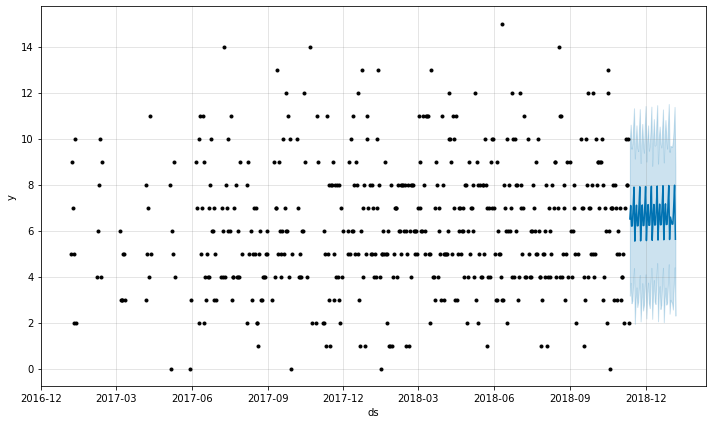

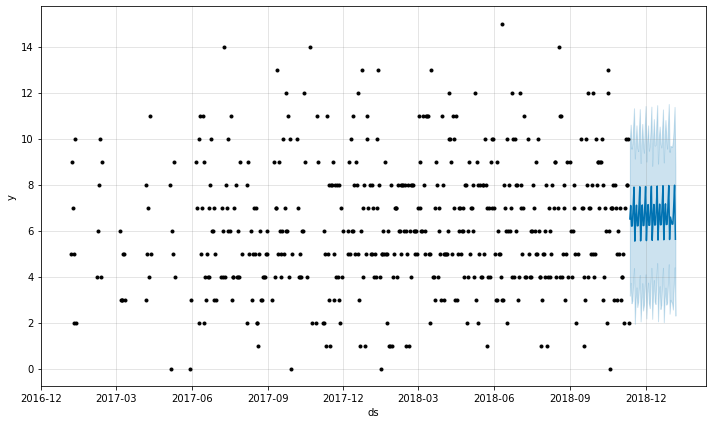

In [35]:
model_chainlubrication.plot(chainlubrication_forecast)

#### **GENERAL SERVICE**

In [37]:
generalservice_df = pd.read_csv('general_service_tsdata.csv')

In [38]:
generalservice_df.columns = ['ds', 'y']
generalservice_df['ds']= pd.to_datetime(generalservice_df['ds'])

In [39]:
generalservice_df.describe()

,y
count,552.000000
mean,3.880435
std,2.278324
min,0.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,13.000000


In [40]:
test_size = 0.10*generalservice_df.shape[0]
generalservice_df_train = generalservice_df.iloc[:generalservice_df.shape[0]-int(test_size)]
generalservice_df_test = generalservice_df.iloc[-int(test_size):]

In [41]:
model_generalservice = Prophet()
model_generalservice.fit(generalservice_df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [42]:
future = []
for i in list(generalservice_df_test['ds']):
  future.append(str(i).split(' ')[0])

In [43]:
future_df = pd.DataFrame(future)
future_df.columns = ['ds']
future_df['ds']= pd.to_datetime(future_df['ds'])

generalservice_forecast = model_generalservice.predict(future_df)
generalservice_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
50,2019-01-02,4.405980,1.433991,7.044831,4.405102,4.406864,-0.240013,-0.240013,-0.240013,-0.240013,-0.240013,-0.240013,0.0,0.0,0.0,4.165967
51,2019-01-03,4.407683,0.986532,6.747656,4.406778,4.408574,-0.501190,-0.501190,-0.501190,-0.501190,-0.501190,-0.501190,0.0,0.0,0.0,3.906493
52,2019-01-04,4.409386,1.959418,7.438688,4.408448,4.410304,0.215946,0.215946,0.215946,0.215946,0.215946,0.215946,0.0,0.0,0.0,4.625332
53,2019-01-05,4.411089,2.909931,8.233532,4.410119,4.412044,1.189435,1.189435,1.189435,1.189435,1.189435,1.189435,0.0,0.0,0.0,5.600523
54,2019-01-06,4.412792,0.753114,6.019171,4.411789,4.413768,-0.904632,-0.904632,-0.904632,-0.904632,-0.904632,-0.904632,0.0,0.0,0.0,3.508159


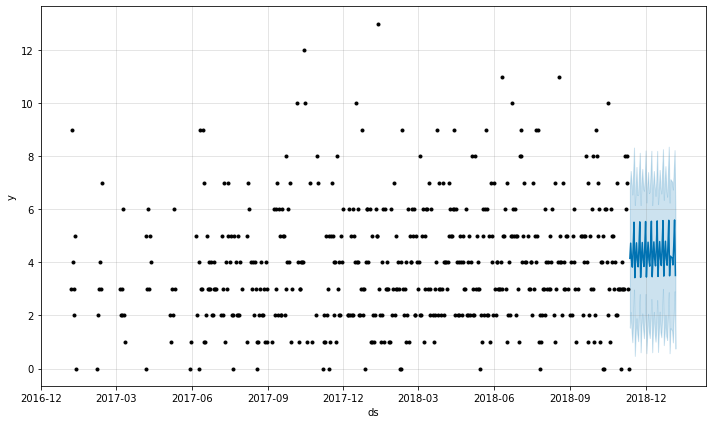

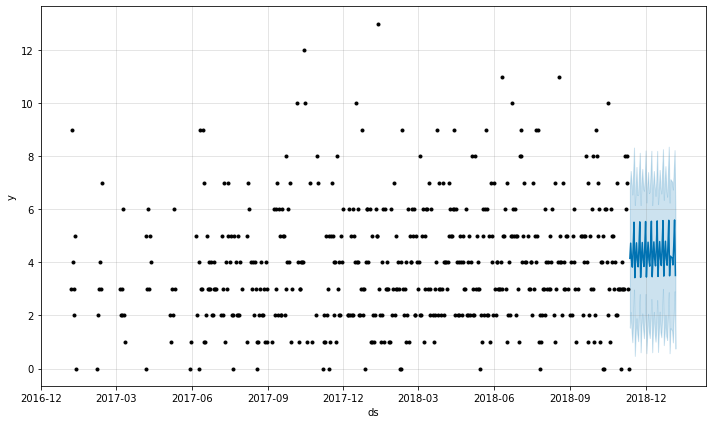

In [44]:
## lets plot
model_generalservice.plot(generalservice_forecast)

For all three classes, from plot it is clear that fbprophet model is forecasting in a uniform pattern for a range of dates. It is not performing well.

## **Selecing best model**
In this Approach 2 comparing with all tried models, we can see Auto Regression model is better for all the three classes.

**Saving models**

In [63]:
from statsmodels.tsa.ar_model import AutoRegResults

In [67]:
## saving engineoil AR model

model_ar_engineoil_fit.save('model_ar_engineoil.pb')
loaded_engineoil_model = AutoRegResults.load('model_ar_engineoil.pb')
forecasted = loaded_engineoil_model.forecast(5)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [68]:
forecasted

497    15.205025
498     4.842961
499     5.815462
500    11.860959
501     7.631669
dtype: float64

In [70]:
pred_engineoil = loaded_engineoil_model.predict(start=len(engineoil_df_train), end=len(engineoil_df_train)+9, dynamic=False)

In [73]:
pred_engineoil = round(pred_engineoil, 0)

In [74]:
pred_engineoil

497    15.0
498     5.0
499     6.0
500    12.0
501     8.0
502     6.0
503    10.0
504     9.0
505    12.0
506    10.0
dtype: float64

In [75]:
pred_engineoil.index = engineoil_df.index[len(engineoil_df_train):len(engineoil_df_train)+10]
pred_engineoil

Date
2018-11-12    15.0
2018-11-13     5.0
2018-11-14     6.0
2018-11-15    12.0
2018-11-16     8.0
2018-11-17     6.0
2018-11-18    10.0
2018-11-19     9.0
2018-11-20    12.0
2018-11-21    10.0
dtype: float64

In [76]:
## saving chainlubricarion AR model

model_ar_chainlubrication_fit.save('model_ar_chainlubrication.pb')
loaded_chainlubrication_model = AutoRegResults.load('model_ar_chainlubrication.pb')
forecasted = loaded_chainlubrication_model.forecast(5)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [77]:
forecasted

497    12.829404
498     6.384287
499     4.192637
500     9.078444
501     8.189469
dtype: float64

In [79]:
pred_chainlubrication = loaded_chainlubrication_model.predict(start=len(chainlubrication_df_train), end=len(chainlubrication_df_train)+9, dynamic=False)
pred_chainlubrication = round(pred_chainlubrication, 0)
pred_chainlubrication.index = chainlubrication_df.index[len(chainlubrication_df_train):len(chainlubrication_df_train)+10]
pred_chainlubrication

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Date
2018-11-12    13.0
2018-11-13     6.0
2018-11-14     4.0
2018-11-15     9.0
2018-11-16     8.0
2018-11-17     6.0
2018-11-18    12.0
2018-11-19     8.0
2018-11-20    10.0
2018-11-21     9.0
dtype: float64

In [80]:
## saving generalservice AR model

model_ar_generalservice_fit.save('model_ar_generalservice.pb')
loaded_generalservice_model = AutoRegResults.load('model_ar_generalservice.pb')
forecasted = loaded_generalservice_model.forecast(5)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [81]:
forecasted

497    0.094982
498    3.730807
499    3.086133
500    4.018529
501    5.031319
dtype: float64

In [82]:
pred_generalservice = loaded_generalservice_model.predict(start=len(generalservice_df_train), end=len(generalservice_df_train)+9, dynamic=False)
pred_generalservice = round(pred_generalservice, 0)
pred_generalservice.index = generalservice_df.index[len(generalservice_df_train):len(generalservice_df_train)+10]
pred_generalservice

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Date
2018-11-12    0.0
2018-11-13    4.0
2018-11-14    3.0
2018-11-15    4.0
2018-11-16    5.0
2018-11-17    5.0
2018-11-18    7.0
2018-11-19    8.0
2018-11-20    6.0
2018-11-21    5.0
dtype: float64